# Prerequisites

## Packages

In [ ]:
!pip install -U accelerate peft transformers einops datasets bitsandbytes
!pip install -U matplotlib
# !pip install nbconvert

In [2]:
!pip freeze | egrep "accelerate|peft|transformers|einops|datasets|^torch=|bitsandbytes" 

accelerate==0.29.1
bitsandbytes==0.43.0
datasets==2.18.0
einops==0.7.0
peft==0.10.0
torch==2.2.2
transformers==4.39.3


## Set a seed for reproducibility of the training process

In [6]:
from transformers import set_seed

set_seed(42)

# Load model and tokenizer

## Load model in 4 bit

In [7]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

# Load model
modelpath = "microsoft/phi-2"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,    
    device_map="auto",
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.bfloat16,
    # FA2 does not work yet
    # attn_implementation="flash_attention_2",          
)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.20s/it]


In [5]:
model

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiSdpaAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (final_la

## Load tokenizer

In [8]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(modelpath, use_fast=False)    # fast tokenizer sometimes ignores the added tokens

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
len(tokenizer)

50295

## Add ChatML tokens to tokenizer

In [9]:
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
model.config.eos_token_id = tokenizer.eos_token_id

Note: there is no need to rezise the token embeddings, phi-2 already has embeddings sized for additional tokens. The model's vocab. size is 51200, this means you can add ~700 tokens to the tokenizer without having to resize the embeddings. 

In [15]:
model.model.embed_tokens

Embedding(51200, 2560)

## Prepare LoRA adapters

In [10]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True) 

lora_config = LoraConfig(
    r=32, 
    lora_alpha=32, 
    target_modules = [ "q_proj", "k_proj", "v_proj", "dense" ],
    modules_to_save = ["lm_head", "embed_tokens"],
    lora_dropout=0.1, 
    bias="none", 
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, lora_config)

model.config.use_cache = False

# Load and preprocess dataset

In [11]:
from datasets import load_dataset
from datasets import Dataset, DatasetDict
original_dataset = load_dataset("TokenBender/code_instructions_122k_alpaca_style")
# def transform_example(example):
#     # 提取 'instruction' 和 'output' 作为独立的消息
#     messages = [example['instruction'], example['output']]
#     return {'messages': messages}

In [12]:
def transform_example(example):
    # 将每个instruction和output转换为两条消息
    return {
        'number': [example['number'], example['number'] + 1],
        'messages': [example['instruction'], example['output']]
    }

# 在原始数据集中添加一个递增的数字列，每行两个数字
original_dataset['train'] = original_dataset['train'].add_column(
    'number', [i * 2 for i in range(len(original_dataset['train']))]
)

# 应用转换函数
transformed_data = original_dataset['train'].map(
    transform_example,
    batched=False,
    remove_columns=original_dataset['train'].column_names
)

# 展平转换后的数据集
flat_number = [num for pair in transformed_data['number'] for num in pair]
flat_messages = [msg for pair in transformed_data['messages'] for msg in pair]

# 创建新的数据集
new_dataset = Dataset.from_dict({
    'number': flat_number,
    'messages': flat_messages
})

# 创建新的DatasetDict
new_dataset_dict = DatasetDict({
    'train': new_dataset
})

# 打印新的数据集结构
print(new_dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['number', 'messages'],
        num_rows: 243918
    })
})


In [13]:
print(new_dataset_dict['train'][1])

{'number': 1, 'messages': '# Python code\ndef sum_sequence(sequence):\n  sum = 0\n  for num in sequence:\n    sum += num\n  return sum'}


In [14]:
# t_dataset = new_dataset_dict['train'].select(range(243918))
t_dataset = new_dataset_dict['train'].select(range(1000))
dataset = t_dataset.train_test_split(test_size=0.1,shuffle=False)

In [15]:

# dataset
dataset["train"][1]

{'number': 1,
 'messages': '# Python code\ndef sum_sequence(sequence):\n  sum = 0\n  for num in sequence:\n    sum += num\n  return sum'}

In [16]:
import os
from functools import partial

# Format (chatML) and tokenize dataset
templates=[
    "<|im_start|>assistant\n{msg}<|im_end|>",
    "<|im_start|>user\n{msg}<|im_end|>"
]
IGNORE_INDEX=-100

def tokenize(input, max_length):
    input_ids, attention_mask, labels = [], [], []

    for i,msg in enumerate(input["messages"]):
        isHuman = i%2==0
        msg_chatml=templates[isHuman].format(msg=msg)
        msg_tokenized=tokenizer(msg_chatml, truncation=False, add_special_tokens=False)

        input_ids+=msg_tokenized["input_ids"]
        attention_mask+=msg_tokenized["attention_mask"]
        labels+=[IGNORE_INDEX]*len(msg_tokenized["input_ids"]) if isHuman else msg_tokenized["input_ids"]

    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length],
    }

dataset_tokenized = dataset.map(
    partial(tokenize, max_length=512),
    batched=False,
    num_proc=os.cpu_count(),    # multithreaded
    remove_columns=dataset["train"].column_names  # don't need this anymore, we have tokens from here on
)

Map (num_proc=24): 100%|██████████| 100/100 [00:10<00:00,  9.93 examples/s]


longest sample: 512 tokens


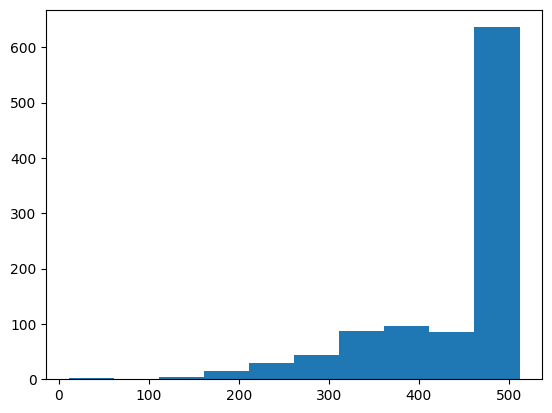

In [17]:
# Sample size distribution
import matplotlib.pyplot as plt

data = [len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])]
print(f"longest sample: {max(data)} tokens")

plt.hist(data, bins=10)
plt.show()

In [18]:
# collate function - to transform list of dictionaries [ {input_ids: [123, ..]}, {.. ] to single batch dictionary { input_ids: [..], labels: [..], attention_mask: [..] }
def collate(elements):
    tokens=[e["input_ids"] for e in elements]
    tokens_maxlen=max([len(t) for t in tokens])

    for i,sample in enumerate(elements):
        input_ids=sample["input_ids"]
        labels=sample["labels"]
        attention_mask=sample["attention_mask"]

        pad_len=tokens_maxlen-len(input_ids)

        input_ids.extend( pad_len * [tokenizer.pad_token_id] )
        labels.extend( pad_len * [IGNORE_INDEX] )
        attention_mask.extend( pad_len * [0] )

    batch={
        "input_ids": torch.tensor( [e["input_ids"] for e in elements] ),
        "labels": torch.tensor( [e["labels"] for e in elements] ),
        "attention_mask": torch.tensor( [e["attention_mask"] for e in elements] ),
    }

    return batch


## Define a collate function, train on answers only

# Train

## Set hyperparameters

In [19]:
from transformers import TrainingArguments, Trainer

# dataset-specific parameters
bs=1     # batch size for training
bs_eval=16    # batch size for evaluation
ga_steps=16  # gradient accumulation steps
lr=0.00002  # learning rate
epochs=20

steps_per_epoch=len(dataset_tokenized["train"])//(bs*ga_steps)

args = TrainingArguments(
    output_dir="/code/out",
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs_eval,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,    # 2 evals per epoch
    save_steps=steps_per_epoch,     # save once per epoch
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit",      # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    bf16=True,        
    ddp_find_unused_parameters=False,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"],
)

/home/zhaw/.local/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  FutureWarning,


In [79]:
!pip install -U wandb

Defaulting to user installation because normal site-packages is not writeable


In [20]:
# log to a specific wandb project
import os
os.environ["WANDB_PROJECT"] = "phi2-code"
os.environ["WANDB_API_KEY"] = "b6eeec460a9c43c95b0df8e8c571e6f3cc09c736"
os.environ["WANDB_MODE"] = "online"
import wandb 
run = wandb.init(
    project="phi2-code",
    name="coderun",
)

wandb: WARNING Path /wandb/ wasn't writable, using system temp directory.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Path /wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /wandb/ wasn't writable, using system temp directory
wandb: Currently logged in as: nikawang. Use `wandb login --relogin` to force relogin


## Start training

In [21]:
trainer.train()

/home/zhaw/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/zhaw/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/zhaw/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460

/home/zhaw/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/zhaw/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/zhaw/.local/lib/python3.10/site-packages/torch/utils/checkpoint.py:460

TrainOutput(global_step=1120, training_loss=0.6765874115750193, metrics={'train_runtime': 6058.1809, 'train_samples_per_second': 2.971, 'train_steps_per_second': 0.185, 'total_flos': 1.356998622521856e+17, 'train_loss': 0.6765874115750193, 'epoch': 19.91})

# After training: Merge LoRA adapters with base model

In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

# base model
base_path="microsoft/phi-2"  

# adapters: path to folder with adapter_model.safetensors
adapter_path="/code/out/checkpoint-1120" 

# where to save merged model
save_to="/code/out/trained_model"       

# Load model and tokenizer
base_model = AutoModelForCausalLM.from_pretrained(
    base_path,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(base_path)

# Add/set tokens same tokens to base model before merging, like we did before training  
tokenizer.add_tokens(["<|im_start|>", "<PAD>"])
tokenizer.pad_token = "<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

# Add ChatML template to tokenizer
tokenizer.chat_template="{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

base_model.config.eos_token_id = tokenizer.eos_token_id

# Set a default Generation configuration: Llama precise
generation_config = GenerationConfig(
    max_new_tokens=100, 
    temperature=0.7,
    top_p=0.1,
    top_k=40,
    repetition_penalty=1.18,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

# Load LoRA and merge
model = PeftModel.from_pretrained(base_model, adapter_path)
model = model.merge_and_unload()

model.save_pretrained(save_to, safe_serialization=True, max_shard_size='4GB')
tokenizer.save_pretrained(save_to)
generation_config.save_pretrained(save_to)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Inference of trained model

In [23]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from peft import PeftModel
import torch

model_path="/code/out/trained_model"    
question="Create a program to convert from Roman numerals to decimal numbers."

model = AutoModelForCausalLM.from_pretrained(
        model_path,    
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )
tokenizer = AutoTokenizer.from_pretrained(model_path) 

messages=[
    {"role": "user", "content": question}
]
        
input_tokens = tokenizer.apply_chat_template(
    messages, 
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

output_tokens = model.generate(input_tokens)
output = tokenizer.decode(
    output_tokens[0][len(input_tokens[0]):],
    skip_special_tokens=True
    )               

print(output)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


roman_numerals = {'I':1, 'V':5, 'X':10, 'L':50, 'C':100, 'D':500, 'M':1000}


i=0
summation=0
while i<len(roman_numerals):
	j=i+1
	if j==len(roman_numerals) or roman_numerals[roman_numerals[


# Upload model to hub

In [24]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
# from transformers 

# Load model and tokenizer
modelpath="/code/out/trained_model"
model = AutoModelForCausalLM.from_pretrained(
    modelpath,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
tokenizer = AutoTokenizer.from_pretrained(modelpath) 

# Upload
model.push_to_hub("nikad/phi-2_code")
tokenizer.push_to_hub("nikad/phi-2_code")

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 8.19k/5.00G [00:00<26:08:30, 53.1kB/s]
model-00001-of-00002.safetensors:   0%|          | 1.31M/5.00G [00:00<44:33, 1.87MB/s]   
model-00001-of-00002.safetensors:   0%|          | 4.26M/5.00G [00:00<12:47, 6.51MB/s]
model-00001-of-00002.safetensors:   0%|          | 9.32M/5.00G [00:01<09:38, 8.63MB/s]
model-00001-of-00002.safetensors:   0%|          | 10.5M/5.00G [00:01<13:14, 6.27MB/s]

model-00001-of-00002.safetensors:   0%|          | 14.8M/5.00G [00:02<08:34, 9.67MB/s]
model-00001-of-00002.safetensors:   0%|          | 16.0M/5.00G [00:02<18:21, 4.52MB/s]

model-00001-of-00002.safetensors:   1%|          | 32.0M/5.00G [00:03<05:49, 14.2MB/s]
model-00001-of-00002.safet

CommitInfo(commit_url='https://huggingface.co/nikad/phi-2_code/commit/5759504df125e0e112aa49393f24c08162875fc1', commit_message='Upload tokenizer', commit_description='', oid='5759504df125e0e112aa49393f24c08162875fc1', pr_url=None, pr_revision=None, pr_num=None)